# DA for DMD cylinder_model.py

In [1]:
import random
from time import perf_counter

import torch
from torch import nn
import torch.nn.functional as F
import numpy
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = True


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)


def set_device():
    """
    Use CPU if cuda device is not available
    setup tf32 for faster GPU computation
    """
    if torch.cuda.device_count() == 0:
        return "cpu"
    torch.set_float32_matmul_precision("high")
    return "cuda"


set_seed(42)
g = torch.Generator()
g.manual_seed(42)
device = set_device()
device

/scratch_dgxl/wy524/miniconda3/envs/irp-env/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


'cpu'

In [2]:
from cylinder_model import CYLINDER_C_FORWARD

forward_model = CYLINDER_C_FORWARD()
forward_model.load_state_dict(torch.load('best_cyl_model_weights/forward_model.pt', weights_only=True, map_location=device))
forward_model.C_forward = torch.load('best_cyl_model_weights/C_forward.pt', weights_only=True, map_location=device)
forward_model.eval()

print(forward_model)

CYLINDER_C_FORWARD(
  (K_S): CYLINDER_K_S(
    (Conv2D_size7_1): Conv2d(2, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (Conv2D_size5_1): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (Conv2D_size3_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Conv2D_size3_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Conv2D_size3_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (pooling): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (relu): ReLU()
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=4096, out_features=512, bias=True)
  )
  (K_S_preimage): CYLINDER_K_S_preimage(
    (linear): Linear(in_features=512, out_features=4096, bias=True)
    (ConvTranspose2D_size3_1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ConvTranspose2D_size3_2): ConvTranspose2d(128, 6

In [3]:
from Dataset import CylinderDynamicsDataset

foward_step = 12

val_idx = 3

cyl_train_dataset = CylinderDynamicsDataset(data_path="../../../data/cylinder/cylinder_train_data.npy",
                seq_length = foward_step,
                mean=None,
                std=None)
    
cyl_val_dataset = CylinderDynamicsDataset(data_path="../../../data/cylinder/cylinder_val_data.npy",
            seq_length = foward_step,
            mean=cyl_train_dataset.mean,
            std=cyl_train_dataset.std)

denorm = cyl_val_dataset.denormalizer()

Loaded Cylinder data with shape: (39, 1000, 2, 64, 64)
dataset total samples: 38532
Loaded Cylinder data with shape: (10, 1000, 2, 64, 64)
dataset total samples: 9880


In [4]:
groundtruth = cyl_val_dataset.data[val_idx, ...]
groundtruth = torch.from_numpy(groundtruth)

groundtruth.shape

torch.Size([1000, 2, 64, 64])

In [5]:
def visualize_image(image_2d, title='Image', cmap='viridis'):
    if isinstance(image_2d, torch.Tensor):
        image_2d = image_2d.detach().cpu().numpy()

    plt.figure(figsize=(2, 2))
    plt.imshow(image_2d, cmap=cmap)
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
import os
import sys
import numpy as np

class UnifiedDynamicSparseObservationHandler:
    def __init__(self, max_obs_ratio: float = 0.15, min_obs_ratio: float = 0.05, seed: int = 42):
        self.max_obs_ratio = max_obs_ratio
        self.min_obs_ratio = min_obs_ratio
        self.seed = seed
        self.fixed_positions = None
        self.max_obs_count = 0
        self.time_masks = {}
        
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
    
    def generate_unified_observations(self, image_shape: tuple, time_steps: list) -> int:
        if len(image_shape) == 3:
            C, H, W = image_shape
        else:
            raise ValueError(f"Expected 3D image shape (C, H, W), got {image_shape}")
        
        total_pixels = C * H * W
        self.max_obs_count = int(total_pixels * self.max_obs_ratio)
        
        self.fixed_positions = torch.randperm(total_pixels)[:self.max_obs_count]
        print(f"Fixed observation positions generated: {self.max_obs_count} positions")
        
        for i, t in enumerate(time_steps):
            obs_ratio = np.random.uniform(self.min_obs_ratio, self.max_obs_ratio)
            num_valid = int(total_pixels * obs_ratio)
            num_valid = min(num_valid, self.max_obs_count)
            
            valid_indices = torch.randperm(self.max_obs_count)[:num_valid]
            
            self.time_masks[i] = {
                'num_valid': num_valid,
                'valid_indices': valid_indices,
                'obs_ratio': obs_ratio
            }
            
            print(f"Time step {t}: {num_valid}/{self.max_obs_count} observations ({obs_ratio:.3f} ratio)")
        
        return self.max_obs_count
    
    def apply_unified_observation(self, full_image: torch.Tensor, time_step_idx: int) -> torch.Tensor:
        if time_step_idx not in self.time_masks:
            raise ValueError(f"Time step index {time_step_idx} not found in masks")
        
        mask_info = self.time_masks[time_step_idx]
        
        flat_image = full_image.flatten()
        fixed_obs = flat_image[self.fixed_positions]
        
        obs_vector = torch.zeros(self.max_obs_count, device=full_image.device)
        valid_indices = mask_info['valid_indices']
        obs_vector[valid_indices] = fixed_obs[valid_indices]
        
        return obs_vector
    
    def create_block_R_matrix(self, base_variance=1e-3):
        R = torch.eye(self.max_obs_count) * base_variance
        return R
    
    def create_unified_R_matrix(self, base_variance: float = 1e-3, 
                               invalid_variance: float = 1.0) -> torch.Tensor:
        R = torch.eye(self.max_obs_count) * invalid_variance
        
        min_valid = min(mask_info['num_valid'] for mask_info in self.time_masks.values())
        
        R[:min_valid, :min_valid] = torch.eye(min_valid) * base_variance
        
        return R

In [7]:
_global_obs_handler = None
_global_time_idx = 0

def update_observation_time_index(time_idx: int):
    global _global_time_idx
    _global_time_idx = time_idx

### DA

In [8]:
import torchda

In [9]:
obs_handler = UnifiedDynamicSparseObservationHandler(
    max_obs_ratio=0.11, 
    min_obs_ratio=0.09, 
    seed=42
)

In [10]:
start_da_end_idxs = (700, 800, 900)

time_obs = [
    start_da_end_idxs[1],
    start_da_end_idxs[1] + 10,
    start_da_end_idxs[1] + 20,
]
gaps = [10] * (len(time_obs) - 1)

full_y_data = [
    cyl_val_dataset.normalize(groundtruth[i+1, ...])
    for i in range(groundtruth.shape[0])
    if i in time_obs
]

full_y_data = torch.cat(full_y_data).to(device)

In [11]:
print(full_y_data.shape)

torch.Size([3, 2, 64, 64])


In [12]:
sample_image_shape = full_y_data[0].shape
max_obs_count = obs_handler.generate_unified_observations(sample_image_shape, range(len(time_obs)))

sparse_y_data = []
for i, full_img in enumerate(full_y_data):
    sparse_obs = obs_handler.apply_unified_observation(full_img, i)
    sparse_y_data.append(sparse_obs)
sparse_y_data = torch.stack(sparse_y_data).to(device)

print(f"Original observation shape: {full_y_data.shape}")
print(f"Dynamic sparse observation shape: {sparse_y_data.shape}")

Fixed observation positions generated: 901 positions
Time step 0: 798/901 observations (0.097 ratio)
Time step 1: 893/901 observations (0.109 ratio)
Time step 2: 857/901 observations (0.105 ratio)
Original observation shape: torch.Size([3, 2, 64, 64])
Dynamic sparse observation shape: torch.Size([3, 901])


In [13]:
def H_unified(x):
    global _global_time_idx, _global_obs_handler
    
    x_reconstructed = forward_model.K_S_preimage(x)
    sparse_obs = _global_obs_handler.apply_unified_observation(
        x_reconstructed.squeeze(), _global_time_idx
    )
    return sparse_obs.unsqueeze(0)

_global_obs_handler = obs_handler

In [14]:
_global_obs_handler = obs_handler

In [15]:
latent_dim = forward_model.C_forward.shape[0]
B = torch.eye(latent_dim, device=device)

R = obs_handler.create_block_R_matrix(base_variance=1e-3).to(device)

obs_dim = sparse_y_data.shape[1]

print(f"Background covariance B shape: {B.shape}")
print(f"Observation dimension: {obs_dim}")

print(f"R matrix shape: {R.shape}")
print(f"R matrix condition number: {torch.linalg.cond(R):.2e}")
print(f"R matrix rank: {torch.linalg.matrix_rank(R)}")
print(f"R matrix is invertible: {torch.linalg.matrix_rank(R) == R.shape[0]}")

Background covariance B shape: torch.Size([512, 512])
Observation dimension: 901
R matrix shape: torch.Size([901, 901])
R matrix condition number: 1.00e+00
R matrix rank: 901
R matrix is invertible: True


In [16]:
def dmd_warpper(z_t, time_fw=None, *args):
    if time_fw == None:
        if z_t.ndim == 1:
            z_t = z_t.unsqueeze(0)

        z_tp = forward_model.latent_forward(z_t)
        
    else:
        if z_t.ndim == 1:
            z_t = z_t.unsqueeze(0)

        z_tp = torch.empty((time_fw.shape[0], z_t.shape[0], z_t.shape[1]), device=z_t.device)
        
        current_state = forward_model.K_S_preimage(z_t)
        
        for i in range(int(time_fw.shape[0])):
            z_current = forward_model.K_S(current_state)
            z_tp[i] = z_current
            
            if i < int(time_fw.shape[0]) - 1:
                z_next = forward_model.latent_forward(z_current)
                current_state = forward_model.K_S_preimage(z_next)
    
    return z_tp

In [ ]:
case_to_run = (
    torchda.CaseBuilder()
    .set_observation_time_steps(time_obs)
    .set_gaps(gaps)
    .set_forward_model(dmd_warpper)
    .set_observation_model(H_unified)
    .set_background_covariance_matrix(B)
    .set_observation_covariance_matrix(R)
    .set_observations(sparse_y_data)
    .set_optimizer_cls(torch.optim.Adam)
    .set_optimizer_args({"lr": 0.05})
    .set_max_iterations(1000)
    .set_algorithm(torchda.Algorithms.Var4D)
    .set_device(torchda.Device.CPU)
    .set_output_sequence_length(1)
)

In [18]:
outs_4d_da = []

start_time = perf_counter()

current_state = cyl_val_dataset.normalize(groundtruth[start_da_end_idxs[0]])

for i in range(start_da_end_idxs[0], start_da_end_idxs[-1] + 1):
    print(f"Processing step {i}")
    
    z_current = forward_model.K_S(current_state)
    
    if i == start_da_end_idxs[1]:
        update_observation_time_index(0)
        
        case_to_run.set_background_state(z_current.ravel())
        result = case_to_run.execute()
        z_assimilated = result["assimilated_state"]
        
        intermediate_results = result["intermediate_results"]
        final_cost = intermediate_results["J"][-1]
        print(f"Final cost function: {final_cost}")
        print(f"Number of iterations: {len(intermediate_results['J'])}")
        
        outs_4d_da.append(z_assimilated)
        
        current_state = forward_model.K_S_preimage(z_assimilated)
    else:
        outs_4d_da.append(z_current)
        
        z_next = dmd_warpper(z_current)
        current_state = forward_model.K_S_preimage(z_next)
    
    print("=" * 50)

print(f"Unified dynamic sparse observation 4D-Var time: {perf_counter() - start_time}s")

Processing step 700
Processing step 701
Processing step 702
Processing step 703
Processing step 704
Processing step 705
Processing step 706
Processing step 707
Processing step 708
Processing step 709
Processing step 710
Processing step 711
Processing step 712
Processing step 713
Processing step 714
Processing step 715
Processing step 716
Processing step 717
Processing step 718


[W711 13:16:46.314294189 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


Processing step 719
Processing step 720
Processing step 721
Processing step 722
Processing step 723
Processing step 724
Processing step 725
Processing step 726
Processing step 727
Processing step 728
Processing step 729
Processing step 730
Processing step 731
Processing step 732
Processing step 733
Processing step 734
Processing step 735
Processing step 736
Processing step 737
Processing step 738
Processing step 739
Processing step 740
Processing step 741
Processing step 742
Processing step 743
Processing step 744
Processing step 745
Processing step 746
Processing step 747
Processing step 748
Processing step 749
Processing step 750
Processing step 751
Processing step 752
Processing step 753
Processing step 754
Processing step 755
Processing step 756
Processing step 757
Processing step 758
Processing step 759
Processing step 760
Processing step 761
Processing step 762
Processing step 763
Processing step 764
Processing step 765
Processing step 766
Processing step 767
Processing step 768


In [19]:
outs_no_4d_da = []
start_time = perf_counter()
with torch.no_grad():
    current_state = cyl_val_dataset.normalize(groundtruth[start_da_end_idxs[0]])
    
    for i in range(start_da_end_idxs[0], start_da_end_idxs[-1] + 1):
        print(i)
        
        z_current = forward_model.K_S(current_state)
        
        outs_no_4d_da.append(z_current)
        
        z_next = forward_model.latent_forward(z_current)
        next_state = forward_model.K_S_preimage(z_next)
        
        current_state = next_state
        print("===============================")
print(f"time elapse for pure dmd: {perf_counter() - start_time}s")

700
701
702
703
704
705
706
707


708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
time elapse for pure dmd: 1.1796331310179085s


In [20]:
real_img = groundtruth

len(outs_4d_da), len(outs_no_4d_da), real_img.shape

(201, 201, torch.Size([1000, 2, 64, 64]))

In [21]:
# diffs = []
diffs_da_real_mse = []
diffs_noda_real_mse = []
diffs_da_real_rrmse = []
diffs_noda_real_rrmse = []
diffs_da_real_ssim = []
diffs_noda_real_ssim = []

with torch.no_grad():
    for i, (no_da, da) in enumerate(zip(outs_no_4d_da, outs_4d_da), start=start_da_end_idxs[0]):
        
        da_img = forward_model.K_S_preimage(da).view(2, 64, 64)
        noda_img = forward_model.K_S_preimage(no_da).view(2, 64, 64)

        de_da_img = denorm(da_img)
        de_noda_img = denorm(noda_img)
        
        da_minus_real_img_square = (de_da_img[0] - real_img[i]) ** 2
        noda_minus_real_img_square = (de_noda_img[0] - real_img[i]) ** 2

        diffs_da_real_mse.append(da_minus_real_img_square.mean())
        diffs_noda_real_mse.append(noda_minus_real_img_square.mean())

        diffs_da_real_rrmse.append((da_minus_real_img_square.sum()/((real_img[i]**2).sum())).sqrt())
        diffs_noda_real_rrmse.append((noda_minus_real_img_square.sum()/((real_img[i]**2).sum())).sqrt())

        diffs_da_real_ssim.append(ssim(real_img[i].numpy(), de_da_img[0].numpy(), data_range=1, channel_axis=0))
        diffs_noda_real_ssim.append(ssim(real_img[i].numpy(), de_noda_img[0].numpy(), data_range=1, channel_axis=0))

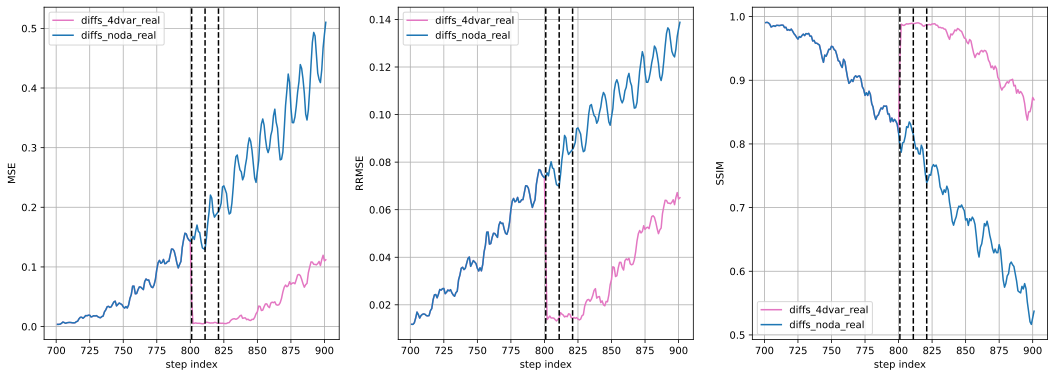

diffs_noda_real_mse[da_idxs[0]]=tensor(0.1456), diffs_noda_real_mse[da_idxs[1]]=tensor(0.1294), diffs_noda_real_mse[da_idxs[2]]=tensor(0.1931)
diffs_da_real_mse[da_idxs[0]]=tensor(0.0424), diffs_da_real_mse[da_idxs[1]]=tensor(0.0057), diffs_da_real_mse[da_idxs[2]]=tensor(0.0055)
diffs_noda_real_rrmse[da_idxs[0]]=tensor(0.0741), diffs_noda_real_rrmse[da_idxs[1]]=tensor(0.0699), diffs_noda_real_rrmse[da_idxs[2]]=tensor(0.0854)
diffs_da_real_rrmse[da_idxs[0]]=tensor(0.0400), diffs_da_real_rrmse[da_idxs[1]]=tensor(0.0147), diffs_da_real_rrmse[da_idxs[2]]=tensor(0.0144)
diffs_noda_real_ssim[da_idxs[0]]=np.float32(0.7983843), diffs_noda_real_ssim[da_idxs[1]]=np.float32(0.8148847), diffs_noda_real_ssim[da_idxs[2]]=np.float32(0.73897445)
diffs_da_real_ssim[da_idxs[0]]=np.float32(0.9343971), diffs_da_real_ssim[da_idxs[1]]=np.float32(0.9889603), diffs_da_real_ssim[da_idxs[2]]=np.float32(0.98649436)


In [22]:
step_idxs = list(range(start_da_end_idxs[0] + 1, start_da_end_idxs[-1] + 2))

_, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].plot(step_idxs, diffs_da_real_mse, color="#e377c2", label="diffs_4dvar_real")
ax[0].plot(step_idxs, diffs_noda_real_mse, color="#1f77b4", label="diffs_noda_real")

ax[1].plot(step_idxs, diffs_da_real_rrmse, color="#e377c2", label="diffs_4dvar_real")
ax[1].plot(step_idxs, diffs_noda_real_rrmse, color="#1f77b4", label="diffs_noda_real")

ax[2].plot(step_idxs, diffs_da_real_ssim, color="#e377c2", label="diffs_4dvar_real")
ax[2].plot(step_idxs, diffs_noda_real_ssim, color="#1f77b4", label="diffs_noda_real")

for i, name in enumerate(["MSE", "RRMSE", "SSIM"]):
    ax[i].set_xlabel("step index")
    ax[i].set_ylabel(name)
    ax[i].grid(True)
    ax[i].legend()
    for x in time_obs:
        ax[i].axvline(x=x+1, color="k", linestyle="--")

plt.show()

da_idxs = [100, 110, 120]
print(f"{diffs_noda_real_mse[da_idxs[0]]=}, {diffs_noda_real_mse[da_idxs[1]]=}, {diffs_noda_real_mse[da_idxs[2]]=}")
print(f"{diffs_da_real_mse[da_idxs[0]]=}, {diffs_da_real_mse[da_idxs[1]]=}, {diffs_da_real_mse[da_idxs[2]]=}")
print(f"{diffs_noda_real_rrmse[da_idxs[0]]=}, {diffs_noda_real_rrmse[da_idxs[1]]=}, {diffs_noda_real_rrmse[da_idxs[2]]=}")
print(f"{diffs_da_real_rrmse[da_idxs[0]]=}, {diffs_da_real_rrmse[da_idxs[1]]=}, {diffs_da_real_rrmse[da_idxs[2]]=}")
print(f"{diffs_noda_real_ssim[da_idxs[0]]=}, {diffs_noda_real_ssim[da_idxs[1]]=}, {diffs_noda_real_ssim[da_idxs[2]]=}")
print(f"{diffs_da_real_ssim[da_idxs[0]]=}, {diffs_da_real_ssim[da_idxs[1]]=}, {diffs_da_real_ssim[da_idxs[2]]=}")

800
1668.9421
213.01346
810
1200.4221
315.68054
820
1460.4622
241.47293


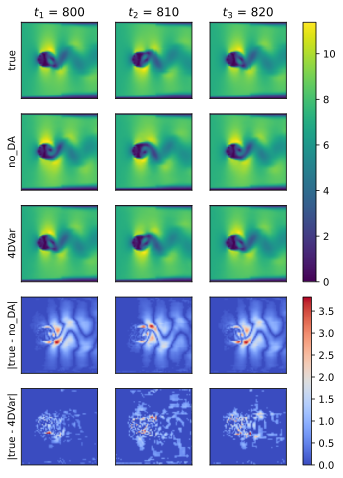

In [23]:
fig, ax = plt.subplots(5, len(da_idxs), figsize=(2 * len(da_idxs), 8), sharex=True)
for x in ax.flat:
    x.set_xticks([])
    x.set_yticks([])
    x.set_xticklabels([])
    x.set_yticklabels([])

setup_cmap = True
with torch.no_grad():
    for i, da_idx in enumerate(da_idxs):
        if i == 0:
            img_tensor = (real_img[time_obs[i]+1, 0, ...] ** 2 + real_img[time_obs[i]+1, 1, ...] ** 2) ** 0.5
        else:
            img_tensor = (real_img[time_obs[i], 0, ...] ** 2 + real_img[time_obs[i], 1, ...] ** 2) ** 0.5
        print(time_obs[i])
        im1 = ax[0, i].imshow(torch.reshape(img_tensor, (64, 64)), cmap="viridis")
        if setup_cmap:
            # Create a ScalarMappable object with the colormap from images
            sm1 = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)
        no_da = forward_model.K_S_preimage(outs_no_4d_da[da_idx]).cpu()
        da = forward_model.K_S_preimage(outs_4d_da[da_idx]).cpu()

        de_no_da = denorm(no_da)
        de_da = denorm(da)

        image_noda = (de_no_da[0, 0, ...] ** 2 + de_no_da[0, 1, ...] ** 2) ** 0.5
        image_da = (de_da[0, 0, ...] ** 2 + de_da[0, 1, ...] ** 2) ** 0.5

        print(np.sum(np.abs(img_tensor.numpy() - image_noda.numpy())))
        print(np.sum(np.abs(img_tensor.numpy() - image_da.numpy())))

        ax[1, i].imshow(torch.reshape(image_noda, (64, 64)), cmap="viridis")
        ax[2, i].imshow(torch.reshape(image_da, (64, 64)), cmap="viridis")
        res = (img_tensor.reshape((64, 64)) - image_noda.reshape((64, 64))).abs()
        res = torch.where(res > 0.1, res, 0)
        im2 = ax[3, i].imshow(res, cmap="coolwarm")
        if setup_cmap:
            sm2 = plt.cm.ScalarMappable(cmap=im2.cmap, norm=im2.norm)
        res = (img_tensor.reshape((64, 64)) - image_da.reshape((64, 64))).abs()
        res = torch.where(res > 0.1, res, 0)
        ax[4, i].imshow(res, cmap="coolwarm")
        setup_cmap = False

for i, title in enumerate([f"$t_1$ = {time_obs[0]}", f"$t_2$ = {time_obs[1]}", f"$t_3$ = {time_obs[2]}"]):
    ax[0, i].set_title(title)
# ax[0].set_title("$t$")
for i, ylabel in enumerate(["true", "no_DA", "4DVar", "|true - no_DA|", "|true - 4DVar|"]):
    ax[i, 0].set_ylabel(ylabel)

# # Create a ScalarMappable object with the colormap from images
# sm1 = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)

# Remove the set_array to avoid warning
sm1.set_array([])

# Add a colorbar to the figure that uses the ScalarMappable
# fig.colorbar(sm1, ax=ax, orientation="vertical")

fig.colorbar(sm1, ax=ax[:-2, :], orientation="vertical")
sm2 = plt.cm.ScalarMappable(cmap=im2.cmap, norm=im2.norm)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[-2:, :], orientation="vertical")

plt.show()